In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists
plt.rcParams["figure.figsize"] = (15,4)

In [52]:
resample = True

### Data Loading

One must have unziped files in data folder. :)

In [10]:
import os
path_raw_files = '../data'
csv_files = [path_raw_files + '/' + file for file in os.listdir(path_raw_files) if '.csv' in file]

In [11]:
# Example of how to load times series csv file
# Each file contains data from approximately 50 devices
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

In [12]:
df = pd.concat(dfs, axis = 0)

In [13]:
df = df.dropna()

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Data cleaning and resampling

In [32]:
diff = df.reset_index()[['battery_id','temperature','state_of_charge_percent','timestamp']].dropna().sort_values(['battery_id','timestamp'])
diff = diff.reset_index(drop = True).reset_index().set_index(['index','battery_id'])
diff[['diff_temp','diff_soc','delta_time']] = diff.groupby('battery_id').diff()
diff['delta_seconds'] = diff['delta_time'].dt.total_seconds()
diff = diff.dropna()

In [33]:
diff = diff.reset_index()

<AxesSubplot:xlabel='battery_id', ylabel='diff_soc'>

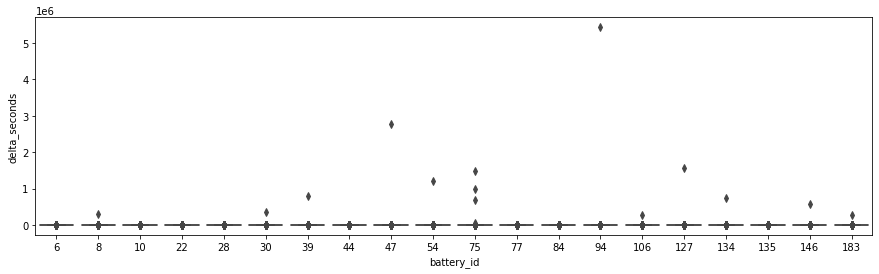

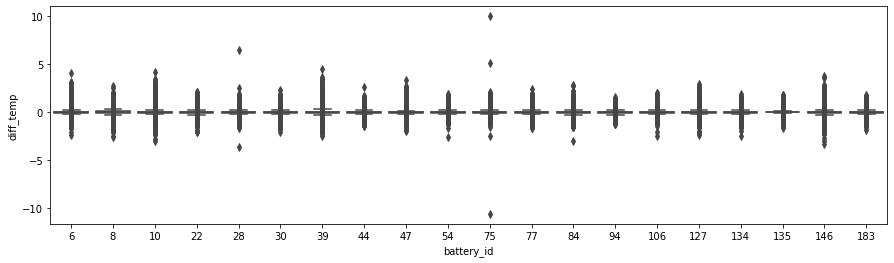

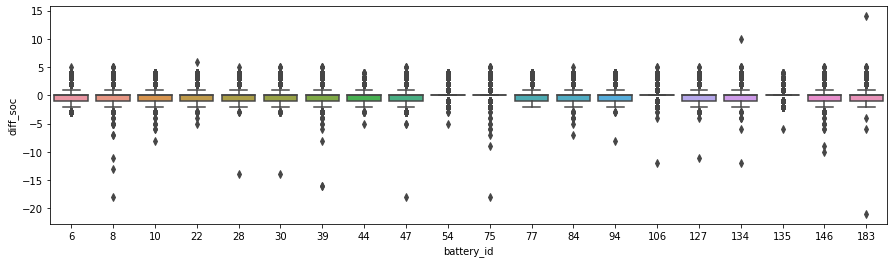

In [34]:
n = 20
random_ids = np.random.choice(diff.battery_id.unique(), n)

df_plot = diff[diff['battery_id'].isin(random_ids)]

sns.boxplot(data = df_plot, x = 'battery_id', y = 'delta_seconds')
plt.figure()
sns.boxplot(data = df_plot, x = 'battery_id', y = 'diff_temp')
plt.figure()
sns.boxplot(data = df_plot,  x = 'battery_id', y = 'diff_soc')

In [44]:
diff['grad_temp_change'] = 60*np.abs(diff['diff_temp']) / diff['delta_seconds']
diff['grad_soc_change'] = 60*np.abs(diff['diff_soc']) / diff['delta_seconds']

<AxesSubplot:xlabel='battery_id', ylabel='grad_soc_change'>

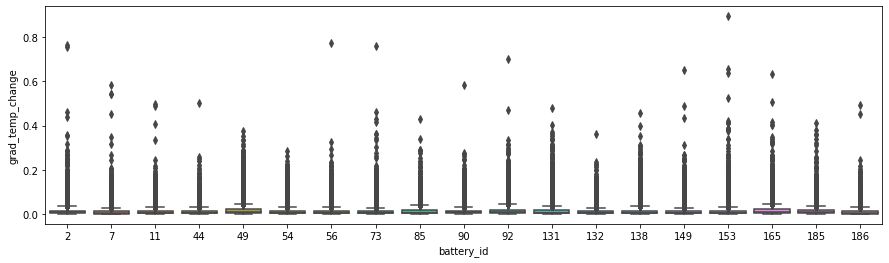

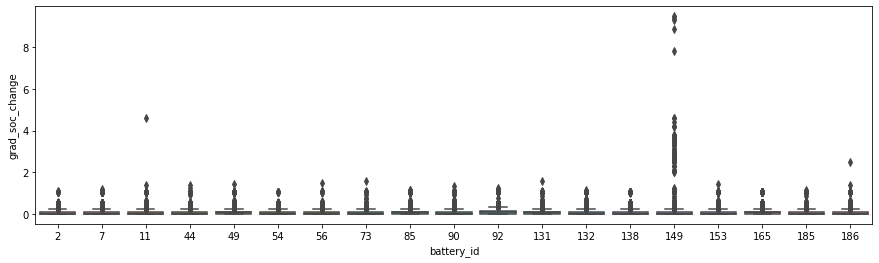

In [46]:
n = 20
random_ids = np.random.choice(diff.battery_id.unique(), n)

df_plot = diff[diff['battery_id'].isin(random_ids)]

sns.boxplot(data = df_plot, x = 'battery_id', y = 'grad_temp_change')
plt.figure()
sns.boxplot(data = df_plot,  x = 'battery_id', y = 'grad_soc_change')

# Feature work

In [48]:
#power and current
df['power_out'] = df['current_out']*df['battery_voltage']
df['usb_power'] = df['usb_current']*df['battery_voltage']
df['power_in'] = df['current_in']*df['battery_voltage']
df['net_power_battery'] = -df['current']*df['battery_voltage']

In [49]:
((df['current_out'] - df['current_in']).round(3) == df['current'].round(3)).mean()

1.0

In [50]:
df['other_out_current'] = df['current_out'] - df['usb_current']

In [51]:
df['bool_current_out'] = df['current_out'] > 2e-2
df['bool_current_in'] = df['current_in'] > 2e-2

# finally resampling

In [53]:
if resample == True:
    df = df.groupby('battery_id').resample('10min').mean()
    df = df.drop('battery_id', axis = 1)

    df = df.reset_index().set_index('timestamp')

In [56]:
df['hour'] = df.index.hour
df['minutes'] = df.index.minute
df['day_n'] = df.index.weekday

In [57]:
df['hour:min'] = df['hour'].astype(str) + ':' + df['minutes'].astype(str)

In [58]:
import os
if os.path.isdir('../data/cleaned_data'):
    print("Exists")
else:
    print("Doesn't exists")
    os.mkdir('../data/cleaned_data')

Exists


In [61]:
file_cleaned_name = "all_dataset"
df.to_parquet(f'../data/cleaned_data/{file_cleaned_name}.parquet')